# Dataloaders

In [1]:
# hide
import sys
sys.path.append("..")
from nbdev.showdoc import *

In [2]:
# export
# default_exp data

import SimpleITK as sitk
import re
import pathlib
import torchvision

from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

In [3]:
# export
from faimed3d.basics import *
from faimed3d.preprocess import *
from faimed3d.augment import *
from faimed3d.widgets.viewer import *


## Get data paths and labels

Data is divided into a train, valid and test dataset of different patients, which either have prostate cancer or are healthy. 
Each patient has three MRI sequences: T2, T1map and ADC. These sequences differ regarding the number of slices and resolution. 

At first, the paths to the data are specified: 

In [4]:
!pwd

/home/miran045/reine097/projects2/faimed3d/nbs


In [5]:
d = pd.read_csv('/home/miran045/reine097/projects/loes-scoring-2/data/all/Nascene_deID_files_short.csv')

In [6]:
d.head()

,index,FILE,QC,NOTES,Gd model Prediction,loes_score,Unnamed: 6,Comments from master spreadsheet,GD?
0,0,sub-01_session-00_space-MNI_002_sub-01_deidentified_18_PEDI_BRAIN_MPRage_SAGIT.nii.gz,2-3,NaN,74.329544,14,NaN,NaN,NaN
1,1,sub-01_session-01_space-MNI_002_sub-01_deidentified_16_PEDI_BRAIN_MPRage_SAGIT.nii.gz,1,NaN,101.094208,15,NaN,NaN,NaN
2,2,sub-02_session-00_space-MNI_103_sub-02_deidentified_MPRAGE_SAG_GD.nii.gz,3,only crisp in coronal,515.427979,18,NaN,NaN,NaN
3,3,sub-02_session-01_space-MNI_002_sub-02_deidentified_T1_FLASH_MPRAGE_SAG.nii.gz,2,minor banding from motion,627.276855,18,NaN,NaN,NaN
4,4,sub-02_session-01_space-MNI_016_sub-02_deidentified_T1_FLASH_MPRAGE_SAG_+C.nii.gz,2,minor banding from motion,499.309357,18,NaN,NaN,NaN


In [7]:
!cd "/home/feczk001/shared/data/loes_scoring/nascene_deid/BIDS/defaced/"

Raw pixel data for DICOM must sometimes undergo affine transformation (e.g. to be converted to Houndsfiel Units). `PreProcessDicom` is a convenience function which can perform a few frequently needed manipulations with the pixel data. 

In [8]:
# export
class PreprocessDicom(DisplayedTransform):
    "Transforms a TensorDicom3D volume to float and normalizes the data"
    def __init__(self, rescale=True,
                 correct_spacing=True, spacing = 1,
                 clip_high_values=False, clipping_range=(-2000, 10000)):
        """
        Args:
            rescale (bool): if pixel values should be scaled according to the rescale intercept and slope
            correct_spacing (bool): if spacing of all volumes should be set to a unified value.
            spacing (int): new pixel spacing, default is 1.
            clip_high_values (bool): if abriatry high values shoule be clipped
            clipping_rang (tuple or list): min and maximum to clip values. important when dealing with beam hardening artifacts.
        """

        store_attr()
    def encodes(self, x:(TensorDicom3D, TensorMask3D)):
        if isinstance(x, TensorMask3D): return x
        if hasattr(x, 'metadata'): # numpy arrays will not have metadata
            if self.rescale: x = x.rescale_pixeldata()
            if self.correct_spacing: x = x.size_correction(self.spacing)
        if self.clip_high_values: x = x.clamp(self.clipping_range[0],
                                              self.clipping_range[1])
        return x.float()

In [9]:
# export 
@patch
def scale_to(t:TensorDicom3D, mean, std):
    mask = t.ne(0) # ne not compatible with __torch_function__ reimplementation
    mean_orig, std_orig = t[mask].mean(), t[mask].std()
    return mean + (t - mean_orig) * (std/std_orig)


class AddChannel(DisplayedTransform):
    "Adds Channels dims, in case they went missing"
    split_idx,order = None, 99
    def __init__(self, p=1.): store_attr()

    def encodes(self, x:Tensor):
        if x.ndim == 3: x = x.unsqueeze(0) # make bs=2 form bs=1 batches
        if x.ndim == 4: x = x.unsqueeze(1)
        return x

In [10]:
# export
def ImageBlock3D(cls=TensorDicom3D, **kwargs):
    "A `TransformBlock` for images of `cls`. For possible kwargs see PreporcessDicom."
    return TransformBlock(type_tfms=cls.create, batch_tfms=[PreprocessDicom(**kwargs)])

def MaskBlock3D(cls=TensorMask3D, codes=None):
    "A `TransformBlock` for images of `cls`. For possible kwargs see PreporcessDicom."
    return TransformBlock(type_tfms=cls.create, item_tfms=AddMaskCodes(codes=codes))

## Dataloaders for image classification

In [11]:
# export
class ImageDataLoaders3D(DataLoaders):
    "Nearly identical to fastai `ImageDataLoaders` but adapted for 3D data with some preprocessing steps added"

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_df(cls, df, path='.', valid_pct=0.2, seed=None, fn_col=0, folder=None, suff='', label_col=1, label_delim=None,
                y_block=None, valid_col=None, item_tfms=None, batch_tfms=None, rescale_method=None, **kwargs):
        "Create from `df` using `fn_col` and `label_col`"

        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        if y_block is None:
            is_multi = (is_listy(label_col) and len(label_col) > 1) or label_delim is not None
            y_block = MultiCategoryBlock if is_multi else CategoryBlock
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)

        if rescale_method is None: rescale_method = MaxScale()
        if item_tfms is not None:
            item_tfms = [rescale_method, *item_tfms] if isinstance(item_tfms, list) else [rescale_method, item_tfms]
        else: item_tfms = rescale_method

        if batch_tfms is not None:
            batch_tfms = [*batch_tfms, AddChannel()] if isinstance(batch_tfms, list) else [batch_tfms, AddChannel()]
        else: batch_tfms = AddChannel()
        if not isinstance(fn_col, list): fn_col = [fn_col]
        
        dblock = DataBlock(blocks=(*[ImageBlock3D(cls=TensorDicom3D) for i in fn_col], y_block),
                           get_x=[ColReader(col, pref=pref, suff=suff) for col in fn_col],
                           get_y=ColReader(label_col, label_delim=label_delim),
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms,
                           n_inp = len(fn_col))
        return cls.from_dblock(dblock, df, path=path,  **kwargs)

    @classmethod
    def from_csv(cls, path, csv_fname='labels.csv', header='infer', delimiter=None, **kwargs):
        "Create from `path/csv_fname` using `fn_col` and `label_col`"
        df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter)
        return cls.from_df(df, path=path, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_folder(cls, path, train='train', valid='valid', valid_pct=None, seed=None, vocab=None, item_tfms=None,
                    batch_tfms=None, rescale_method=None,**kwargs):
        "Create from imagenet style dataset in `path` with `train` and `valid` subfolders (or provide `valid_pct`)"
        
        if rescale_method is None: rescale_method = MaxScale()
        if item_tfms is not None:
            item_tfms = [rescale_method, *item_tfms] if isinstance(item_tfms, list) else [rescale_method, item_tfms]
        else: item_tfms = rescale_method

        if batch_tfms is not None:
            batch_tfms = [*batch_tfms, AddColorChannel()] if isinstance(batch_tfms, list) else [batch_tfms, AddColorChannel()]
        else: batch_tfms = AddColorChannel()
        
        splitter = GrandparentSplitter(train_name=train, valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct, seed=seed)
        get_items = get_volumetric_files if valid_pct else partial(get_volumetric_files, folders=[train, valid])
        dblock = DataBlock(blocks=(ImageBlock3D(cls=TensorDicom3D), CategoryBlock(vocab=vocab)),
                           get_items=get_items,
                           splitter=splitter,
                           get_y=parent_label,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, path, path=path, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_path_func(cls, path, fnames, label_func, valid_pct=0.2, seed=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`"
        raise NotImplementedError('Currently only from_df and from_csv are supported. '
                                  'You can raise a feature request on Github (https://github.com/kbressem/faimed3d/),'
                                  ' if you need this feature implemented. ')

    @classmethod
    def from_name_func(cls, path, fnames, label_func, **kwargs):
        "Create from the name attrs of `fnames` in `path`s with `label_func`"
        f = using_attr(label_func, 'name')
        return cls.from_path_func(path, fnames, f, **kwargs)

    @classmethod
    def from_path_re(cls, path, fnames, pat, **kwargs):
        "Create from list of `fnames` in `path`s with re expression `pat`"
        return cls.from_path_func(path, fnames, RegexLabeller(pat), **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_name_re(cls, path, fnames, pat, **kwargs):
        "Create from the name attrs of `fnames` in `path`s with re expression `pat`"
        return cls.from_name_func(path, fnames, RegexLabeller(pat), **kwargs)

In [12]:
# export
supported_extensions = {'.dcm', '.nii.gz', '.nii', '.nrrd', '.avi', '.npy'}

def get_volumetric_files(path, recurse=True, folders=None):
    "Get medical volumetric files or video in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=supported_extensions, recurse=recurse, folders=folders)

In [13]:
d

,index,FILE,QC,NOTES,Gd model Prediction,loes_score,Unnamed: 6,Comments from master spreadsheet,GD?
0,0,sub-01_session-00_space-MNI_002_sub-01_deidentified_18_PEDI_BRAIN_MPRage_SAGIT.nii.gz,2-3,NaN,74.329544,14,NaN,NaN,NaN
1,1,sub-01_session-01_space-MNI_002_sub-01_deidentified_16_PEDI_BRAIN_MPRage_SAGIT.nii.gz,1,NaN,101.094208,15,NaN,NaN,NaN
2,2,sub-02_session-00_space-MNI_103_sub-02_deidentified_MPRAGE_SAG_GD.nii.gz,3,only crisp in coronal,515.427979,18,NaN,NaN,NaN
3,3,sub-02_session-01_space-MNI_002_sub-02_deidentified_T1_FLASH_MPRAGE_SAG.nii.gz,2,minor banding from motion,627.276855,18,NaN,NaN,NaN
4,4,sub-02_session-01_space-MNI_016_sub-02_deidentified_T1_FLASH_MPRAGE_SAG_+C.nii.gz,2,minor banding from motion,499.309357,18,NaN,NaN,NaN
5,5,sub-02_session-01_space-MNI_100_sub-02_deidentified_T1_FLASH_MPRAGE_SAG.nii.gz,3,only crisp in coronal,473.965668,18,NaN,NaN,NaN
6,6,sub-02_session-01_space-MNI_101_sub-02_deidentified_T1_FLASH_MPRAGE_SAG.nii.gz,3,only crisp in axial,621.878601,18,NaN,NaN,NaN
7,7,sub-02_session-01_space-MNI_102_sub-02_deidentified_T1_FLASH_MPRAGE_SAG_+C.nii.gz,3,only crisp in coronal,594.326965,18,NaN,NaN,NaN
8,8,sub-02_session-01_space-MNI_103_sub-02_deidentified_T1_FLASH_MPRAGE_SAG_+C.nii.gz,3,only crisp in axial,458.512115,18,NaN,NaN,NaN
9,9,sub-02_session-02_space-MNI_103_sub-02_deidentified_SAG_T1_MPRAGE.nii.gz,3,NaN,669.267090,18,NaN,NaN,NaN


In [14]:
def get_full_path(row):
   return os.path.join('/home/feczk001/shared/data/loes_scoring/nascene_deid/BIDS/defaced/', row['FILE'])

In [15]:
d['full_path'] = d.apply(get_full_path, axis=1)

In [16]:
d.head()

,index,FILE,QC,NOTES,Gd model Prediction,loes_score,Unnamed: 6,Comments from master spreadsheet,GD?,full_path
0,0,sub-01_session-00_space-MNI_002_sub-01_deidentified_18_PEDI_BRAIN_MPRage_SAGIT.nii.gz,2-3,NaN,74.329544,14,NaN,NaN,NaN,/home/feczk001/shared/data/loes_scoring/nascene_deid/BIDS/defaced/sub-01_session-00_space-MNI_002_sub-01_deidentified_18_PEDI_BRAIN_MPRage_SAGIT.nii.gz
1,1,sub-01_session-01_space-MNI_002_sub-01_deidentified_16_PEDI_BRAIN_MPRage_SAGIT.nii.gz,1,NaN,101.094208,15,NaN,NaN,NaN,/home/feczk001/shared/data/loes_scoring/nascene_deid/BIDS/defaced/sub-01_session-01_space-MNI_002_sub-01_deidentified_16_PEDI_BRAIN_MPRage_SAGIT.nii.gz
2,2,sub-02_session-00_space-MNI_103_sub-02_deidentified_MPRAGE_SAG_GD.nii.gz,3,only crisp in coronal,515.427979,18,NaN,NaN,NaN,/home/feczk001/shared/data/loes_scoring/nascene_deid/BIDS/defaced/sub-02_session-00_space-MNI_103_sub-02_deidentified_MPRAGE_SAG_GD.nii.gz
3,3,sub-02_session-01_space-MNI_002_sub-02_deidentified_T1_FLASH_MPRAGE_SAG.nii.gz,2,minor banding from motion,627.276855,18,NaN,NaN,NaN,/home/feczk001/shared/data/loes_scoring/nascene_deid/BIDS/defaced/sub-02_session-01_space-MNI_002_sub-02_deidentified_T1_FLASH_MPRAGE_SAG.nii.gz
4,4,sub-02_session-01_space-MNI_016_sub-02_deidentified_T1_FLASH_MPRAGE_SAG_+C.nii.gz,2,minor banding from motion,499.309357,18,NaN,NaN,NaN,/home/feczk001/shared/data/loes_scoring/nascene_deid/BIDS/defaced/sub-02_session-01_space-MNI_016_sub-02_deidentified_T1_FLASH_MPRAGE_SAG_+C.nii.gz


In [17]:
# export
class ImageDataLoaders3D(DataLoaders):
    "Nearly identical to fastai `ImageDataLoaders` but adapted for 3D data with some preprocessing steps added"

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_df(cls, df, path='.', valid_pct=0.2, seed=None, fn_col=0, folder=None, suff='', label_col=1, label_delim=None,
                y_block=None, valid_col=None, item_tfms=None, batch_tfms=None, rescale_method=None, **kwargs):
        "Create from `df` using `fn_col` and `label_col`"

        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        if y_block is None:
            is_multi = (is_listy(label_col) and len(label_col) > 1) or label_delim is not None
            y_block = MultiCategoryBlock if is_multi else CategoryBlock
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)

        if rescale_method is None: rescale_method = MaxScale()
        if item_tfms is not None:
            item_tfms = [rescale_method, *item_tfms] if isinstance(item_tfms, list) else [rescale_method, item_tfms]
        else: item_tfms = rescale_method

        if batch_tfms is not None:
            batch_tfms = [*batch_tfms, AddChannel()] if isinstance(batch_tfms, list) else [batch_tfms, AddChannel()]
        else: batch_tfms = AddChannel()
        if not isinstance(fn_col, list): fn_col = [fn_col]
        
        dblock = DataBlock(blocks=(*[ImageBlock3D(cls=TensorDicom3D) for i in fn_col], y_block),
                           get_x=[ColReader(col, pref=pref, suff=suff) for col in fn_col],
                           get_y=ColReader(label_col, label_delim=label_delim),
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms,
                           n_inp = len(fn_col))
        return cls.from_dblock(dblock, df, path=path,  **kwargs)

    @classmethod
    def from_csv(cls, path, csv_fname='labels.csv', header='infer', delimiter=None, **kwargs):
        "Create from `path/csv_fname` using `fn_col` and `label_col`"
        df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter)
        return cls.from_df(df, path=path, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_folder(cls, path, train='train', valid='valid', valid_pct=None, seed=None, vocab=None, item_tfms=None,
                    batch_tfms=None, rescale_method=None,**kwargs):
        "Create from imagenet style dataset in `path` with `train` and `valid` subfolders (or provide `valid_pct`)"
        
        if rescale_method is None: rescale_method = MaxScale()
        if item_tfms is not None:
            item_tfms = [rescale_method, *item_tfms] if isinstance(item_tfms, list) else [rescale_method, item_tfms]
        else: item_tfms = rescale_method

        if batch_tfms is not None:
            batch_tfms = [*batch_tfms, AddColorChannel()] if isinstance(batch_tfms, list) else [batch_tfms, AddColorChannel()]
        else: batch_tfms = AddColorChannel()
        
        splitter = GrandparentSplitter(train_name=train, valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct, seed=seed)
        get_items = get_volumetric_files if valid_pct else partial(get_volumetric_files, folders=[train, valid])
        dblock = DataBlock(blocks=(ImageBlock3D(cls=TensorDicom3D), CategoryBlock(vocab=vocab)),
                           get_items=get_items,
                           splitter=splitter,
                           get_y=parent_label,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, path, path=path, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_path_func(cls, path, fnames, label_func, valid_pct=0.2, seed=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`"
        raise NotImplementedError('Currently only from_df and from_csv are supported. '
                                  'You can raise a feature request on Github (https://github.com/kbressem/faimed3d/),'
                                  ' if you need this feature implemented. ')

    @classmethod
    def from_name_func(cls, path, fnames, label_func, **kwargs):
        "Create from the name attrs of `fnames` in `path`s with `label_func`"
        f = using_attr(label_func, 'name')
        return cls.from_path_func(path, fnames, f, **kwargs)

    @classmethod
    def from_path_re(cls, path, fnames, pat, **kwargs):
        "Create from list of `fnames` in `path`s with re expression `pat`"
        return cls.from_path_func(path, fnames, RegexLabeller(pat), **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_name_re(cls, path, fnames, pat, **kwargs):
        "Create from the name attrs of `fnames` in `path`s with re expression `pat`"
        return cls.from_name_func(path, fnames, RegexLabeller(pat), **kwargs)

In [18]:
dls = ImageDataLoaders3D.from_df(d, 
                                 fn_col = 'full_path', 
                                 label_col = 'loes_score',
                                 path='/',
                                 item_tfms = ResizeCrop3D(crop_by = (0., 0.1, 0.1), 
                                                          resize_to = (20, 150, 150), 
                                                          perc_crop = True),
                                 bs = 2, 
                                 )

In [19]:
from fastai.data.core import DataLoaders # for compatibility with show_docs

In [20]:
# export
@patch
def show_batch_3d(dls:DataLoaders, with_mask=False, alpha_mask=0.3, figsize = (4, 4), viewer = 'widget', max_n = 9, **kwargs):
    "Show batch of DataLoader either with simple moasik view or using the DICOM viewer widget"
    
    assert viewer in ['widget', 'mosaik'], 'viewer must be of type `widget` or `mosaik`'
    batch = dls.decode_batch(dls.one_batch(), max_n = max_n)
    xb, yb = list(map(list, zip(*batch)))
    
    if viewer == 'mosaik':
        xb = torch.stack(xb)
        show_images_3d(xb, figsize=figsize, **kwargs)
        if with_mask: 
            yb = torch.stack(yb)
            show_imges_3d(yb, add_to_existing = True, alpha = alpha_mask,
                    cmap = 'jet', figsize=figsize, **kwargs)
        if isinstance(yb, TensorCategory): print(yb)
    if viewer == 'widget':
        xb = [x.squeeze() for x in xb]
        assert xb[0].ndim == 3, 'Currently multiple inputs are not supported'
        if isinstance(yb[0], TensorMask3D): 
            yb = [y.squeeze() for y in yb] if with_mask else None
        elif isinstance(yb[0], MultiCategory): yb = [', '.join(y) for y in yb]
        ListViewer(x=xb, y=yb, figsize=figsize,  max_n = max_n, **kwargs).show()

/panfs/jay/groups/4/miran045/reine097/projects2/faimed3d/nbs/faimed3d/basics.py:264: UserWarning: Object is not a rank 3 tensor but a rank 4 tensor. Removing the first dimension
  warn('Object is not a rank 3 tensor but a rank {} tensor. Removing the first dimension'.format(t.ndim))


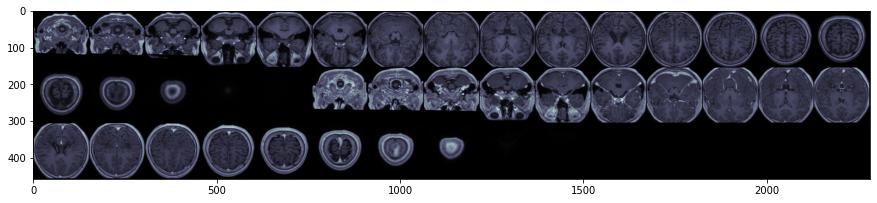

In [21]:
dls.show_batch_3d(viewer='mosaik', nrow = 15, figsize=(15, 15))

In [22]:
from torch import Tensor # for show_docs

In [23]:
# export
@patch
def to_numpy(x:Tensor): return x.detach().cpu().numpy()

@patch
def show_hist(dls:DataLoaders, bins=100, with_stats=False):
    xb, yb = dls.one_batch()

    if with_stats:
        b_min = xb.min().to_numpy()
        b_max = xb.max().to_numpy()
        mean = torch.mean(xb)
        diffs = xb - mean
        var = torch.mean(torch.pow(diffs, 2.0))
        std = torch.pow(var, 0.5)
        zscores = diffs / std
        skews = torch.mean(torch.pow(zscores, 3.0))
        kurt = torch.mean(torch.pow(zscores, 4.0)) - 3.0
        print('batch mean: {}, std: {}'.format(mean.to_numpy(), std.to_numpy()))
        print('px range: {} - {}'.format(b_min, b_max))
        print('skewness: {}, kurtosis:{}'.format(skews.to_numpy(), kurt.to_numpy()))

    plt.hist(xb.detach().cpu().flatten().numpy(), bins = bins)

batch mean: 0.21877948939800262, std: 0.18831095099449158
px range: 0.0 - 1.0
skewness: 0.3070239722728729, kurtosis:-0.8344230651855469


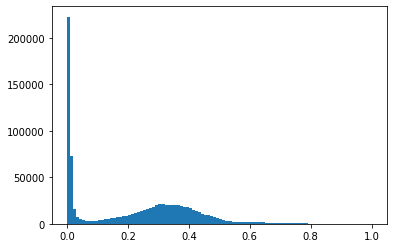

In [24]:
dls.show_hist(with_stats=True)

# ResNet

In [25]:
# default_exp models.resnet
# export
from fastai.basics import *
from fastai.layers import *
from warnings import warn
from torch.hub import load_state_dict_from_url

## ResNet 3D

Same code as the ResNet implementation on torchvision, just replacing 2D modules with 3D modules

### Building blocks

In [26]:
# export
from torchvision.models.resnet import Bottleneck, BasicBlock

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv3d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv3d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

from torch import nn # prevent error in nbdev with re-importing nn (was already imported with fastai)
class BasicBlock3d(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, act_layer=None):
        super(BasicBlock3d, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm3d
        if act_layer is None:
            act_layer = partial(nn.ReLU, inplace=True)
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = act_layer()
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck3d(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, act_layer=None):
        super(Bottleneck3d, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm3d
        if act_layer is None:
            act_layer = partial(nn.ReLU, inplace=True)
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = act_layer()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)


        return out

In [27]:
BasicBlock3d(4, 64, norm_layer=partial(nn.BatchNorm3d, affine = False))

BasicBlock3d(
  (conv1): Conv3d(4, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
)

In [28]:
Bottleneck3d(4, 64)

Bottleneck3d(
  (conv1): Conv3d(4, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

### Identity layer

Medical images, especially 3D images are large so batch size is limited when trainig in normal consumer hardware. This can lead to problems with the normalization layers, as performance can/will decrease for batch sizes under 32/under 8. 
This is discussed [here](https://stackoverflow.com/questions/59648509/batch-normalization-when-batch-size-1), [here](https://luminovo.ai/blog/a-refresher-on-batch-re-normalization) and [here](https://www.alexirpan.com/2017/04/26/perils-batch-norm.html). Replacing the normalization layer with an indentity layer might be a quick solution without the need to alter the whole architecture. 

In [29]:
# export
class IdentityLayer(nn.Module):
    "Returns input as is"
    def __init__(self, *args, **kwargs):
        super(IdentityLayer, self).__init__()
    def forward(self, x):
        return x

### ResNet basic module
Same as the ResNet module from torchvision, but all 2D submodules have been changed to 3D, and MaxPool has a kernel size of (1,3,3), to avoid reduction of the depth to 1 (depth of medical images can be very small).  

In [30]:
# export
class ResNet3D(nn.Module):

    def __init__(self, block, layers, n_channels=3, num_classes=101, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, act_layer=None, final_softmax=False, ps = 0.5):
        super(ResNet3D, self).__init__()
        if norm_layer is None: norm_layer = nn.BatchNorm3d
        if act_layer is None: act_layer = partial(nn.ReLU, inplace=True)
        self._norm_layer = norm_layer
        self.inplanes = 128 if isinstance(block(1,1), Bottleneck3d) else 32

        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group

        self.stem = nn.Sequential(nn.Conv3d(n_channels, self.inplanes, kernel_size=(2, 5, 5), stride=(1, 3, 3), padding=1, bias=False),
                                  norm_layer(self.inplanes),
                                  act_layer(inplace=True))

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Sequential(
            nn.BatchNorm1d(512 * block.expansion, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=ps/2, inplace=False),
            nn.Linear(512 * block.expansion, 256),
            act_layer(inplace=True),
            nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=ps, inplace=False),
            nn.Linear(1, num_classes,bias = False))

        if final_softmax:
            self.fc = nn.Sequential(self.fc,
                                    nn.Softmax(1))

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm3d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck3d):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock3d):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _encoder(self, x1):
        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)
        return x2, x3, x4, x5

    def _head(self, x5):
        x = self.avgpool(x5)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.stem(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def forward(self, x):
        return self._forward_impl(x)

## ResNet architectures

Note that a pretrained ResNet18 for 3D already exists at `torchvision.models.video`

In [32]:
# export
_model_urls = {
           'resnet18_3d': 'https://rad-ai.charite.de/pretrained_models/resnet18_3d_ucf100.pth', 
           'resnet34_3d': 'https://rad-ai.charite.de/pretrained_models/resnet34_3d_ucf100.pth', 
           'resnet50_3d': 'https://rad-ai.charite.de/pretrained_models/resnet50_3d_ucf100.pth', 
           'resnet101_3d': 'https://rad-ai.charite.de/pretrained_models/resnet101_3d_ucf100.pth'
          }

In [33]:
# export

def _resnet_3d(arch, block, layers, pretrained=False, progress=False, **kwargs):
    "similar to the _resnet function of pytorch. Has same Args as resnet for compatibility, but does not us them all"
    model = ResNet3D(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(_model_urls[arch],
                                              progress=True)
        model.load_state_dict(state_dict['model'])
    return model

In [38]:
# export
def resnet18_3d(pretrained=False, progress=False, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    adapted to 3d
    """
    return _resnet_3d('resnet18_3d', BasicBlock3d, [2, 2, 2, 2], pretrained=pretrained, progress=progress,**kwargs)


def resnet34_3d(pretrained=False, progress=False, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    adapted to 3d
    """
    return _resnet_3d('resnet34_3d', BasicBlock3d, [3, 4, 6, 3], pretrained=pretrained, progress=progress,**kwargs)


def resnet50_3d(pretrained=False, progress=False,**kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    adapted to 3d
    """
    return _resnet_3d('resnet50_3d', Bottleneck3d, [3, 4, 6, 3], pretrained=pretrained, progress=progress,**kwargs)


def resnet101_3d(pretrained=False, progress=False, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`
    adapted to 3d
    """
    return _resnet_3d('resnet101_3d', Bottleneck3d, [3, 4, 23, 3], pretrained=pretrained, progress=progress,**kwargs)


def resnet152_3d(pretrained=False, progress=False, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`
    adapted to 3d
    """
    # currently no pretrained version. Might follow in the future
    if pretrained: warn('Currently there is no pretrained version available for `resnet152_3d`. Will load randomly intilialized weights.')
    return _resnet_3d(None, Bottleneck3d, [3, 8, 36, 3], pretrained=False, progress=False,**kwargs)

# Learner

In [34]:
# export
# default_exp learner
from fastai.basics import *
from fastai.callback.all import *

In [35]:
# export
from faimed3d.basics import *
from faimed3d.augment import *
from faimed3d.preprocess import *
from faimed3d.layers import *
from faimed3d.data import *
from faimed3d.models.unet import DynamicUnet3D
from faimed3d.models.deeplab import DynamicDeepLab
from faimed3d.models.losses import DiceLoss
from fastai.vision.learner import _default_meta, _add_norm, model_meta

In [36]:
# export
@delegates(Learner.__init__)
def cnn_learner_3d(dls, arch, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, cbs=None, **kwargs):
    """
    Build a convnet style learner from `dls` and `arch`
    Same as fastai func but adds the `AddColorChannel` callback.
    """
    if config is None: config = {}
    meta = model_meta.get(arch, _default_meta)
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    # if normalize: _add_norm(dls, meta, pretrained) # no effect as no TenosrImage is passed in 3d
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')

    model = create_cnn_model_3d(arch, n_out, ifnone(cut, meta['cut']), pretrained, n_in=dls.n_inp, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=ifnone(splitter, meta['split']), **kwargs)
    if pretrained: learn.freeze()
    return learn

In [39]:
from torchvision.models.video import r3d_18
learn = cnn_learner_3d(dls, resnet18_3d, pretrained=False, loss_func=F.l1_loss) # pretrained turned off for more speed while testing, default would be to load a pretrained model